In [105]:
%pip install pandas seaborn matplotlib scikit-learn pyyaml tensorflow-hub
%pip uninstall -y bert-for-tf2

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [106]:
import os
import math
import datetime
import yaml

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [107]:
print(tf.__version__)

2.9.2


In [108]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [109]:
texts = []

# load training data
with open("training_data.yml", "r") as stream:
    try:
        file = yaml.safe_load(stream)

        for intent in file:
            for utterance in file[intent]["utterances"]:
                texts.append([utterance, intent])
    except yaml.YAMLError as exc:
        print(exc)

df = pd.DataFrame(texts, columns = ['text', 'intent'])

train, test = train_test_split(df, test_size=0.3, stratify=df["intent"])

print(len(train))
print(len(test))

40
18


In [110]:
train

,text,intent
15,What country do you call home?,where_from
41,what is your favorite color?,favorite_colour
35,do you speak french?,what_languages_speak
21,Where is your apartment?,where_live
55,are you flesh or are you metal?,robot
13,Where were you born?,where_from
8,Top of the morning,greeting
57,are you a real AI?,robot
0,Hello,greeting
30,When is your birthday?,how_old


In [111]:
test

,text,intent
2,Greetings,greeting
31,what languages do you speak?,what_languages_speak
7,Morning,greeting
33,do you speak danish?,what_languages_speak
27,How old are you?,how_old
6,Evening,greeting
4,Yo,greeting
17,place of origin?,where_from
50,are you a machine?,robot
39,is danish your native language?,what_languages_speak


In [112]:
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "intent"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [113]:
tokenizer = FullTokenizer(
  vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt")
)

In [114]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

In [115]:
classes = train.intent.unique().tolist()

data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

40it [00:00, 13888.42it/s]
/var/folders/m1/z8wqf0wj5lx2z_96b549v36h0000gn/T/ipykernel_4889/1182966404.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x), np.array(y)
18it [00:00, 15087.42it/s]

max seq_len 10


In [116]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 10, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x40321f670> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [117]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 10)]              0         
                                                                 
 bert (BertModelLayer)       (None, 10, 768)           108890112 
                                                                 
 lambda_5 (Lambda)           (None, 768)               0         
                                                                 
 dropout_10 (Dropout)        (None, 768)               0         
                                                                 
 dense_10 (Dense)            (None, 768)               590592    
                                                                 
 dropout_11 (Dropout)        (None, 768)               0         
                                                                 
 dense_11 (Dense)            (None, 8)                 6152

In [118]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [119]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=25,
  shuffle=True,
  epochs=100,
  callbacks=[tensorboard_callback]
)

Epoch 1/100


/Users/simon/miniforge3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2022-06-08 20:47:20.950156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 2.3593 - acc: 0.2222 

2022-06-08 20:47:48.245651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 39s 17s/step - loss: 2.3593 - acc: 0.2222 - val_loss: 2.3523 - val_acc: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 4s 2s/step - loss: 2.1404 - acc: 0.1944 - val_loss: 2.3554 - val_acc: 0.0000e+00
Epoch 3/100
2/2 [==============================] - 3s 2s/step - loss: 2.2628 - acc: 0.1944 - val_loss: 2.3300 - val_acc: 0.0000e+00
Epoch 4/100
2/2 [==============================] - 3s 2s/step - loss: 2.1049 - acc: 0.2778 - val_loss: 2.3187 - val_acc: 0.0000e+00
Epoch 5/100
2/2 [==============================] - 2s 893ms/step - loss: 1.9029 - acc: 0.3333 - val_loss: 2.3173 - val_acc: 0.0000e+00
Epoch 6/100
2/2 [==============================] - 2s 1s/step - loss: 1.9966 - acc: 0.3611 - val_loss: 2.3143 - val_acc: 0.5000
Epoch 7/100
2/2 [==============================] - 2s 1s/step - loss: 1.6868 - acc: 0.4167 - val_loss: 2.3021 - val_acc: 0.5000
Epoch 8/100
2/2 [==============================] - 1s 718ms/step - loss: 1.7885 - acc: 0.30

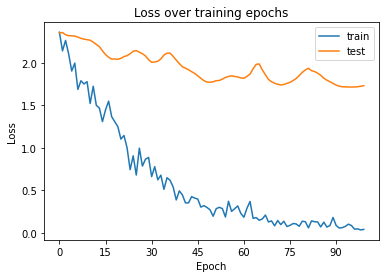

In [120]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [121]:
y_pred = model.predict(data.test_x).argmax(axis=-1)
print(classification_report(data.test_y, y_pred, target_names=classes))

2022-06-08 20:49:12.216609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 7s 7s/step
                      precision    recall  f1-score   support

          where_from       1.00      1.00      1.00         2
     favorite_colour       1.00      1.00      1.00         1
what_languages_speak       1.00      1.00      1.00         3
          where_live       1.00      0.67      0.80         3
               robot       0.75      1.00      0.86         3
            greeting       1.00      1.00      1.00         4
             how_old       1.00      1.00      1.00         1
          where_work       1.00      1.00      1.00         1

            accuracy                           0.94        18
           macro avg       0.97      0.96      0.96        18
        weighted avg       0.96      0.94      0.94        18



Text(0.5, 14.09375, 'Predicted label')

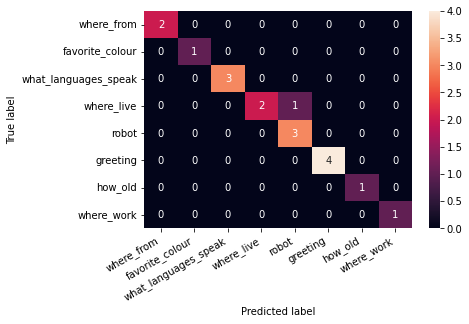

In [126]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [124]:
sentences = [
  "Hello",
  "Yo pal",
  "Where are you from??",
  "where do you live?",
  "what is your favorite color?",
  "are you a robot?"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids)

# print(predictions)

i = 0
for text, label in zip(sentences, predictions.argmax(axis=-1)):
  print("text:", text, "\nintent:", classes[label], "\nconfidence: ", predictions[i][label])
  print()
  i += 1

1/1 [==============================] - 4s 4s/step
text: Hello 
intent: greeting 
confidence:  0.9970362

text: Yo pal 
intent: greeting 
confidence:  0.9954018

text: Where are you from?? 
intent: where_from 
confidence:  0.94499683

text: where do you live? 
intent: where_live 
confidence:  0.9507836

text: what is your favorite color? 
intent: favorite_colour 
confidence:  0.94733363

text: are you a robot? 
intent: robot 
confidence:  0.99022806

